# Analysis of DDRR module

## Load data
Notes:

1. Only singlets are included

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
from pathlib import Path
import re
import seaborn as sns
import scipy
from statannotations.Annotator import Annotator
import rushd as rd
from scipy.optimize import curve_fit

# Required descriptors for annotate
from statannotations.stats.StatTest import StatTest
from scipy.stats import ttest_ind
custom_long_name = 't-test for independent samples from scipy with greater 1-way (mean of the distribution underlying the first sample is greater than the mean of the distribution underlying the second sample)'
custom_short_name = 't-test_ind_greater'
custom_func = ttest_ind
ttest_ind_greater = StatTest(custom_func, custom_long_name, custom_short_name, alternative='greater')

custom_long_name = 't-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample)'
custom_short_name = 't-test_ind_less'
custom_func = ttest_ind
ttest_ind_less = StatTest(custom_func, custom_long_name, custom_short_name, alternative='less')

# Look at 4 dpi data

## Load data

In [2]:
# Directories
base_datadir = rd.datadir/'2023.05.16_HG_6F-addin_4-7_4dpi'
figpath = '../figures/fig2/'

# List of ctrls and samples
ctrl_list = ['Ctrl-RIDDW', 'Ctrl-puro', 'Ctrl-NIL']
cond_list = ['Ctrl-puro', 'NIL', 'NIL.DD+RR', 'NIL.DDIR', 'NIL.RIDD']
DDRR_list = ['no DDRR', 'DD+RR', 'DDIR', 'RIDD']

# Store all data in list of dfs which will be converted to df at end
data_4dpi_all = list()

# get all csvs for each dir
dir_list_1 = ['2023.05.16_HG_NIL-DDRRopt-addin_1_4dpi', '2023.05.16_HG_NIL-DDRRopt-addin_2_4dpi']
for (j, dir_name) in enumerate(dir_list_1):
    
     # Load as df and note header is on 0th row
    df = rd.flow.load_csv_with_metadata(
        base_datadir/dir_name/'export_singlets', base_datadir/'well_metadata_NIL-DDRRopt-addin-1-2.yaml')
    data_4dpi_all.append(df)


# get all csvs for each dir
dir_list_2 = ['2023.05.23_HG_NIL-DDRRopt-addin_3_4dpi', '2023.05.23_HG_NIL-DDRRopt-addin_4_4dpi']
for (j, dir_name) in enumerate(dir_list_2):
    
     # Load as df and note header is on 0th row
    df = rd.flow.load_csv_with_metadata(
        base_datadir/dir_name/'export_singlets', base_datadir/'well_metadata_NIL-DDRRopt-addin-3-4.yaml')
    data_4dpi_all.append(df)


# Convert list of dfs into single df
data_4dpi_all = pd.concat(data_4dpi_all, ignore_index=True)

# Remove negative data
data_4dpi_all = data_4dpi_all.loc[
    (data_4dpi_all['FSC-A'] > 0) &
    (data_4dpi_all['SSC-A'] > 0) &
    (data_4dpi_all['eGFP-A'] > 0) &
    (data_4dpi_all['CellTrace-FarRed-A'] > 0)
]

# Separate out ctrl and sample data
data_4dpi_ctrl = data_4dpi_all[ data_4dpi_all['cond'].isin(ctrl_list) ]
data_4dpi = data_4dpi_all[ data_4dpi_all['cond'].isin(cond_list) ]

## Categorize cells
### Categorize cells based on CellTrace-FarRed

In [3]:
# Get CTFR-low threshold for each rep s.t.
# CTFR_low_thresh = 20% dimmest in ctrl
rep_list = data_4dpi.rep.unique()
CTFR_low_thresh_list = np.zeros(np.shape(rep_list))
for (i, rep) in enumerate(rep_list):
    CTFR_low_thresh_list[i] = np.percentile(
        data_4dpi.loc[(data_4dpi['cond'] == 'Ctrl-puro') &
            (data_4dpi['rep'] == rep)
        ]['CellTrace-FarRed-A'], 20)

# Categorize based on CTFR for each rep
data_4dpi['CTFR_cat'] = 'CTFR-low'
for (i, rep) in enumerate(rep_list):
    data_4dpi.loc[
        (data_4dpi['rep'] == rep_list[i]) &
        (data_4dpi['CellTrace-FarRed-A'] > CTFR_low_thresh_list[i]),
        'CTFR_cat'] = 'non-CTFR-low'

# Calculate CTFR populations using these metrics
well_group = ['rep', 'cond']
count_df_reps = data_4dpi.groupby([*well_group, 'well', 'CTFR_cat'])[
    'FSC-A'].count().unstack(fill_value=0).stack().rename('count') # Puts 0 if none rather than dropping row
CTFR_percent_4dpi_reps = (count_df_reps*100/count_df_reps.groupby([*well_group, 'well']
                           ).transform('sum')).reset_index(name='percent')

# Extract just the hyperP
CTFR_hyperP_count_4dpi_reps = (count_df_reps).reset_index(name='count')
CTFR_hyperP_count_4dpi_reps = CTFR_hyperP_count_4dpi_reps.loc[(CTFR_hyperP_count_4dpi_reps['CTFR_cat'] == 'CTFR-low')]
seedNum = 10**4 # Seeded 10k MEFs/96-well
CTFR_hyperP_yield_4dpi_reps = (count_df_reps*100/seedNum).reset_index(name='yield')
CTFR_hyperP_yield_4dpi_reps = CTFR_hyperP_yield_4dpi_reps.loc[(CTFR_hyperP_yield_4dpi_reps['CTFR_cat'] == 'CTFR-low')]

CTFR_hyperP_percent_4dpi_reps = CTFR_percent_4dpi_reps.loc[(CTFR_percent_4dpi_reps['CTFR_cat'] == 'CTFR-low')]

# Reduce to bio reps
CTFR_hyperP_percent_4dpi = CTFR_hyperP_percent_4dpi_reps.groupby(well_group)['percent'].mean().reset_index()
CTFR_hyperP_yield_4dpi = CTFR_hyperP_yield_4dpi_reps.groupby(well_group)['yield'].mean().reset_index()
CTFR_hyperP_count_4dpi = CTFR_hyperP_count_4dpi_reps.groupby(well_group)['count'].mean().reset_index()

/var/folders/2d/h4qyrjcd68x7g4p2qdv30s8h0000gn/T/ipykernel_16096/1881040834.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_4dpi['CTFR_cat'] = 'CTFR-low'
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


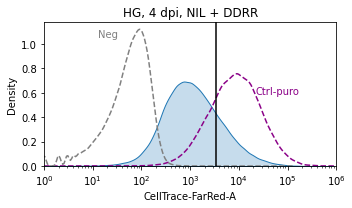

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

# Threshold for iMNs
rep = 1
CTFR_low_thresh = CTFR_low_thresh_list[rep-1]

# Plot CTFR-A
x = 'CellTrace-FarRed-A'
sns.kdeplot(data=data_4dpi.loc[
    (data_4dpi['cond'] == 'NIL.RIDD') & (data_4dpi['rep'] == rep)],
    ax=ax, x=x,
    common_norm=False, log_scale=(True, False),
    fill=True)

# Plot CTFR control
sns.kdeplot(data=data_4dpi_ctrl[(data_4dpi_ctrl['cond'] == 'Ctrl-puro')], x=x, common_norm=False,
            ax=ax, log_scale=(True, False), color='#8b0288', fill=False, linestyle='--')
ax.annotate('Ctrl-puro', (0.8, 0.5), color='#8b0288' , xycoords='axes fraction', ha='center')

# Plot neg ctrl
sns.kdeplot(data=data_4dpi_ctrl[(data_4dpi_ctrl['cond'] == 'Ctrl-RIDDW')], x=x, common_norm=False,
            ax=ax, log_scale=(True, False), color='grey', fill=False, linestyle='--')
ax.annotate('Neg', (0.22, 0.9), color='grey', xycoords='axes fraction', ha='center')

# Plot threshold
ax.axvline(CTFR_low_thresh, 0, 1, color='black')

# Title
plt.title('HG, 4 dpi, NIL + DDRR')
# Adjust limits
CTFR_lim = (1, 1*10**6)
for sub_ax in plt.gcf().get_axes():
    sub_ax.set_xlim(CTFR_lim)

# Misc plotting stuff
fig.tight_layout()  # Helps improve white spacing
# plt.savefig(figpath + '4dpi_CTFR_dist.svg', bbox_inches='tight')

### Categorize cells based on eGFP

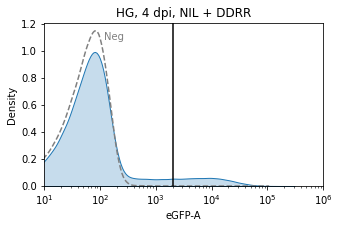

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

# Threshold for early eGFP
eGFP_A_thresh = 2*10**3

# Plot eGFP-A
x = 'eGFP-A'
sns.kdeplot(data=data_4dpi.loc[(data_4dpi['cond'] == 'NIL.RIDD')],
        ax=ax, x=x,
        common_norm=False, log_scale=(True, False),
        fill=True)

# Plot neg ctrl
sns.kdeplot(data=data_4dpi_ctrl[(data_4dpi_ctrl['cond'] == 'Ctrl-RIDDW')], x=x, common_norm=False,
            ax=ax, log_scale=(True, False), color='grey', fill=False, linestyle='--')
ax.annotate('Neg', (0.25, 0.9), color='grey', xycoords='axes fraction', ha='center')

# Plot threshold
ax.axvline(eGFP_A_thresh, 0, 1, color='black')

# Title
plt.title('HG, 4 dpi, NIL + DDRR')
# Adjust limits
eGFP_lim = (10, 1*10**6)
for sub_ax in plt.gcf().get_axes():
    sub_ax.set_xlim(eGFP_lim)

In [6]:
# Categorize cells based on eGFP_thresh
data_4dpi['eGFP_cat'] = 'eGFP-'
data_4dpi.loc[(data_4dpi['eGFP-A'] > eGFP_A_thresh), 'eGFP_cat'] = 'eGFP+'

# Get total counts and percent of GFP-H+
well_group = ['rep', 'cond']
count_df_reps = data_4dpi.groupby([*well_group, 'well', 'eGFP_cat'])[
    'FSC-A'].count().unstack(fill_value=0).stack().rename('count') # Puts 0 if no GFP-H+ rather than dropping row # Try size ??
percent_df_reps = (count_df_reps*100/count_df_reps.groupby([*well_group, 'well']).transform('sum')).reset_index(name='percent')

# Extract just the eGFP+ cells
data_4dpi_eGFP_percent_reps = percent_df_reps.loc[(percent_df_reps['eGFP_cat'] == 'eGFP+')]
# Reduce to bio reps
data_4dpi_eGFP_percent = data_4dpi_eGFP_percent_reps.groupby(well_group)['percent'].mean().reset_index()

/var/folders/2d/h4qyrjcd68x7g4p2qdv30s8h0000gn/T/ipykernel_16096/2862881606.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_4dpi['eGFP_cat'] = 'eGFP-'
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


## Plot eGFP vs. HyperP at 4 dpi
### View all

In [7]:
# Integrate hyperP % and eGFP+% at 4 dpi into single df
percent_4dpi_reps = CTFR_hyperP_percent_4dpi_reps.rename(columns={"percent":"hyperP_percent"}, copy=True)
percent_4dpi_reps.drop(columns='CTFR_cat', inplace=True)

percent_4dpi_reps.loc[:,'eGFP_percent'] = 0
for index, row in percent_4dpi_reps.iterrows():

    eGFP_percent = data_4dpi_eGFP_percent_reps.loc[
        (data_4dpi_eGFP_percent_reps['rep']==row.rep) & 
        (data_4dpi_eGFP_percent_reps['well']==row.well) & 
        (data_4dpi_eGFP_percent_reps['cond']==row.cond)
        ]['percent']
    percent_4dpi_reps.loc[index, 'eGFP_percent'] = float(eGFP_percent)

    hyperP_yield = CTFR_hyperP_yield_4dpi_reps.loc[
        (CTFR_hyperP_yield_4dpi_reps['rep']==row.rep) & 
        (CTFR_hyperP_yield_4dpi_reps['well']==row.well) & 
        (CTFR_hyperP_yield_4dpi_reps['cond']==row.cond)
        ]['yield']
    percent_4dpi_reps.loc[index, 'hyperP_yield'] = float(hyperP_yield)

# Condense tech reps
grouping = ['cond', 'rep']
percent_4dpi = percent_4dpi_reps.groupby(grouping).mean().reset_index()

### Collapse it down a bit

Text(0.5, 1.0, 'HG, 4 dpi')

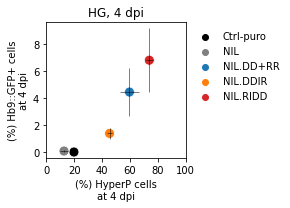

In [8]:
# Calc mean and SEM for each cond
grouping = ['cond']
percent_4dpi_mean = percent_4dpi.groupby(grouping).mean().reset_index()
percent_4dpi_SEM = percent_4dpi.groupby(grouping).sem().reset_index()

# Plotting params
x = 'hyperP_percent'
y = 'eGFP_percent'
hue = 'cond'
cond_list = ['Ctrl-puro', 
             'NIL',
             'NIL.DD+RR', 'NIL.DDIR', 'NIL.RIDD']
palette = {
    'Ctrl-puro': 'black',
    'NIL': 'grey',
    'NIL.DD+RR': 'tab:blue',
    'NIL.DDIR': 'tab:orange',
    'NIL.RIDD': 'tab:red'}

# Plot
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5))

ax.errorbar(x=percent_4dpi_mean[x], y=percent_4dpi_mean[y],
            xerr=percent_4dpi_SEM[x], yerr=percent_4dpi_SEM[y],
            color='None', ecolor='black', elinewidth=0.5)
            
f = sns.scatterplot(ax=ax,
    data=percent_4dpi_mean,
    x=x, y=y, hue=hue, hue_order=cond_list,
    s=100, palette=palette)

sns.move_legend(ax, title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)
ax.xaxis.set_label_text('(%) HyperP cells\nat 4 dpi')
ax.yaxis.set_label_text('(%) Hb9::GFP+ cells\nat 4 dpi')
ax.set_xticks(np.arange(0, 110, 20))
ax.set_yticks(np.arange(0, 8.1, 2))
plt.title('HG, 4 dpi')

# plt.savefig(figpath + 'SI/4dpi_eGFP_v_hyperP.svg', bbox_inches='tight')

# Look at 14 dpi data

## Load 14 dpi data

In [9]:
# Directories
base_datadir = rd.datadir/'2023.05.26_HG_6F-addin_4-7_14dpi'

# List of ctrls and samples
ctrl_list = ['Ctrl-RIDDW', 'Ctrl-puro', 'Ctrl-NIL']
cond_list = ['Ctrl-puro', 'NIL', 'NIL.DD+RR', 'NIL.DDIR', 'NIL.RIDD']
DDRR_list = ['no DDRR', 'DD+RR', 'DDIR', 'RIDD']


# Store all data in list of dfs which will be converted to df at end
data_14dpi_all = list()

# get all csvs for each dir
dir_list_1 = ['2023.05.26_HG_NIL-DDRRopt-addin_1_14dpi', '2023.05.26_HG_NIL-DDRRopt-addin_2_14dpi']
for (j, dir_name) in enumerate(dir_list_1):
    
     # Load as df and note header is on 0th row
    df = rd.flow.load_csv_with_metadata(
        base_datadir/dir_name/'export_singlets', base_datadir/'well_metadata_NIL-DDRRopt-addin-1-2.yaml')
    data_14dpi_all.append(df)


# get all csvs for each dir
dir_list_2 = ['2023.06.02_HG_NIL-DDRRopt-addin_3_14dpi', '2023.06.02_HG_NIL-DDRRopt-addin_4_14dpi']
for (j, dir_name) in enumerate(dir_list_2):
    
     # Load as df and note header is on 0th row
    df = rd.flow.load_csv_with_metadata(
        base_datadir/dir_name/'export_singlets', base_datadir/'well_metadata_NIL-DDRRopt-addin-3-4.yaml')
    data_14dpi_all.append(df)


# Convert list of dfs into single df
data_14dpi_all = pd.concat(data_14dpi_all, ignore_index=True)

# Remove negative data
data_14dpi_all = data_14dpi_all.loc[
    (data_14dpi_all['FSC-A'] > 0) &
    (data_14dpi_all['SSC-A'] > 0) &
    (data_14dpi_all['eGFP-A'] > 0)]

# Separate out ctrl and sample data
data_14dpi_ctrl = data_14dpi_all[ data_14dpi_all['cond'].isin(ctrl_list) ]
data_14dpi = data_14dpi_all[ data_14dpi_all['cond'].isin(cond_list) ]

## Look at eGFP for NILDDRR to determine eGFP gate

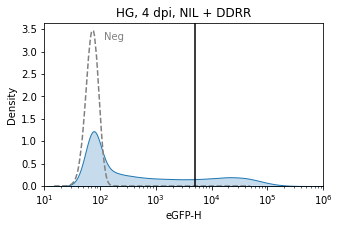

In [10]:
# Threshold for iMNs
eGFP_H_thresh = 5*10**3

# Plot eGFP-H
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
x = 'eGFP-H'
sns.kdeplot(data=data_14dpi.loc[(data_14dpi['cond'] == 'NIL.RIDD')],
        ax=ax, x=x,
        common_norm=False, log_scale=(True, False),
        fill=True)

# Plot neg ctrl
sns.kdeplot(data=data_14dpi_ctrl[(data_14dpi_ctrl['cond'] == 'Ctrl-RIDDW')], x=x, common_norm=False,
            ax=ax, log_scale=(True, False), color='grey', fill=False, linestyle='--')
ax.annotate('Neg', (0.25, 0.9), color='grey', xycoords='axes fraction', ha='center')

# Plot threshold
ax.axvline(eGFP_H_thresh, 0, 1, color='black')

# Title
plt.title('HG, 4 dpi, NIL + DDRR')
# Adjust limits
eGFP_lim = (10, 10**6)
for sub_ax in plt.gcf().get_axes():
    sub_ax.set_xlim(eGFP_lim)

In [11]:
# Categorize iMNs based on eGFP_thresh
data_14dpi.loc[:, 'eGFP_cat'] = 'fib'
data_14dpi.loc[(data_14dpi['eGFP-H'] > eGFP_H_thresh), 'eGFP_cat'] = 'iMN'

# Get total counts and percent of GFP-H+
well_group = ['rep', 'cond']
count_df_reps = data_14dpi.groupby([*well_group, 'well', 'eGFP_cat'])[
    'FSC-A'].count().unstack(fill_value=0).stack().rename('count') # Puts 0 if no GFP-H+ rather than dropping row
percent_df_reps = (count_df_reps*100/count_df_reps.groupby([*well_group, 'well']).transform('sum')).reset_index(name='percent')

# Get iMN yield per condition
seedNum = 10**4 # Seeded 10k MEFs/96-well
data_iMN_yield_reps = (count_df_reps*100/seedNum).reset_index(name='yield')

# Extract just the iMNs
data_iMN_yield_reps = data_iMN_yield_reps.loc[(data_iMN_yield_reps['eGFP_cat'] == 'iMN')]
data_iMN_percent_reps = percent_df_reps.loc[(percent_df_reps['eGFP_cat'] == 'iMN')]

# Reduce to bio reps
data_iMN_yield = data_iMN_yield_reps.groupby(well_group)['yield'].mean().reset_index()
data_iMN_percent = data_iMN_percent_reps.groupby(well_group)['percent'].mean().reset_index()

/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


## Selectivity and yield

Selectivity

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL.DD+RR vs. NIL.DDIR: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=1.234e-01
NIL.DDIR vs. NIL.RIDD: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=-1.125e-01
NIL.DD+RR vs. NIL.RIDD: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=7.216e-03


/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Text(-5.625, 0.5, '(%) iMN\nof all cells')

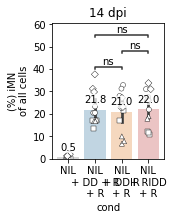

In [12]:
# General plotting params
x = 'cond'
y = 'percent'
cond_list = ['NIL',
             'NIL.DD+RR', 'NIL.DDIR', 'NIL.RIDD']
pairs = [
    ('NIL.DD+RR', 'NIL.DDIR'),
    ('NIL.DD+RR', 'NIL.RIDD'),
    ('NIL.RIDD', 'NIL.DDIR')
]
palette = {
    'NIL': 'grey',
    'NIL.DD+RR': 'tab:blue',
    'NIL.DDIR': 'tab:orange',
    'NIL.RIDD': 'tab:red'}

marker_list = ['o', 's', '^', 'D']
units = 'well'

fig, ax = plt.subplots(1, 1, figsize=(2, 2.5))

# Plot iMN percent of all cells
sns.barplot(ax=ax, data=data_iMN_percent_reps,
            x=x, y=y, order=cond_list, units=units,
            alpha=0.3, palette=palette,)
for (i, rep) in enumerate(data_iMN_percent_reps.rep.unique()):
    sns.stripplot(ax=ax, data=data_iMN_percent_reps[data_iMN_percent_reps.rep == rep],
                x=x, y=y, order=cond_list,
                dodge=True, marker=marker_list[i],
                color='white', size=5,
                edgecolor='black', linewidth=0.4,)

# Add in stats
annot = Annotator(ax=ax, data=data_iMN_percent, x=x, y=y,
                  pairs=pairs, order=cond_list)
annot.configure(test='t-test_ind', comparisons_correction='Bonferroni', text_format='star', loc='inside', verbose=2)
annot.apply_and_annotate()

# Add barplot labels
for sub_ax in plt.gcf().get_axes():
    for i in sub_ax.containers:
        bar_labels = sub_ax.bar_label(i, fmt='%0.1f', padding=5)
        for label in bar_labels:
            label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))    

# Format
# ax.set_box_aspect(3/len(ax.patches)) #change 10 to modify the y/x axis ratio
# fig.tight_layout()  # Helps improve white spacing
ax.set_xticklabels(
    ['NIL',
     'NIL\n+ DD + R\n+ R', 'NIL\n+ DDIR\n+ R', 'NIL\n+ RIDD\n+ R'])
ax.set_title('14 dpi')
ax.set_yticks(np.arange(0, 70, 10))
ax.yaxis.set_label_text('(%) iMN\nof all cells')

# plt.savefig(figpath + '14dpi_iMN_percent_label.svg', bbox_inches='tight')

Yield

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL.DD+RR vs. NIL.DDIR: t-test independent samples with Bonferroni correction, P_val:1.205e-03 t=4.167e+00
NIL.DDIR vs. NIL.RIDD: t-test independent samples with Bonferroni correction, P_val:3.747e-03 t=-3.726e+00
NIL.DD+RR vs. NIL.RIDD: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=-1.288e-01


/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Text(-12.0, 0.5, '(%) iMN yield\nper MEF plated')

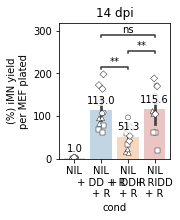

In [13]:
# General plotting params
x = 'cond'
y = 'yield'
cond_list = ['NIL',
             'NIL.DD+RR', 'NIL.DDIR', 'NIL.RIDD']
pairs = [
    ('NIL.DD+RR', 'NIL.DDIR'),
    ('NIL.DD+RR', 'NIL.RIDD'),
    ('NIL.RIDD', 'NIL.DDIR')
]
palette = {
    'NIL': 'grey',
    'NIL.DD+RR': 'tab:blue',
    'NIL.DDIR': 'tab:orange',
    'NIL.RIDD': 'tab:red'}

marker_list = ['o', 's', '^', 'D']
units = 'well'

fig, ax = plt.subplots(1, 1, figsize=(2, 2.5))

# Plot iMN yield of all cells
sns.barplot(ax=ax, data=data_iMN_yield_reps,
            x=x, y=y, order=cond_list, units=units,
            alpha=0.3, palette=palette)
for (i, rep) in enumerate(data_iMN_yield_reps.rep.unique()):
    sns.stripplot(ax=ax, data=data_iMN_yield_reps[data_iMN_yield_reps.rep == rep],
                x=x, y=y, order=cond_list,
                dodge=True, marker=marker_list[i],
                color='white', size=5,
                edgecolor='black', linewidth=0.4,)

# Add in stats
annot = Annotator(ax=ax, data=data_iMN_yield_reps, x=x, y=y,
                  pairs=pairs, order=cond_list)
annot.configure(test='t-test_ind', comparisons_correction='Bonferroni', text_format='star', loc='inside', verbose=2)
annot.apply_and_annotate()

# Add barplot labels
for sub_ax in plt.gcf().get_axes():
    for i in sub_ax.containers:
        bar_labels = sub_ax.bar_label(i, fmt='%0.1f', padding=5)
        for label in bar_labels:
            label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))    

# Format
# fig.tight_layout()  # Helps improve white spacing
ax.set_xticklabels(
    ['NIL',
     'NIL\n+ DD + R\n+ R', 'NIL\n+ DDIR\n+ R', 'NIL\n+ RIDD\n+ R'])
ax.set_title('14 dpi')
# ax.set_xticks(np.arange(0, 50, 10))
ax.yaxis.set_label_text('(%) iMN yield\nper MEF plated')
# plt.savefig(figpath + '14dpi_iMN_yield_label.svg', bbox_inches='tight')

## Look at 4 dpi hyperP vs. iMN

In [14]:
# Copy dataframe of hyperP 4 dpi cells that will integrate with the 14 dpi data and rename column to be clear
data_both_reps = CTFR_hyperP_percent_4dpi_reps.rename(columns={"percent":"4dpi HyperP percent"}, copy=True)
data_both_reps.drop(columns='CTFR_cat', inplace=True)

# Integrate iMN yield and percent into 4 dpi data
for index, row in data_both_reps.iterrows():
    # If puro, ignore
    if row.cond == 'Ctrl-puro': 
        continue
    # Get iMN yield
    iMN_yield = data_iMN_yield_reps.loc[
        (data_iMN_yield_reps['rep']==row.rep) & 
        (data_iMN_yield_reps['cond']==row.cond) &
        (data_iMN_yield_reps['well']==row.well)
        ]['yield']
    # Get iMN percent
    iMN_percent = data_iMN_percent_reps.loc[
        (data_iMN_percent_reps['rep']==row.rep) & 
        (data_iMN_percent_reps['cond']==row.cond) &
        (data_iMN_percent_reps['well']==row.well)
        ]['percent']
    # Get 4 dpi hyperP yield
    hyperP_yield = CTFR_hyperP_yield_4dpi_reps.loc[
        (CTFR_hyperP_yield_4dpi_reps['rep']==row.rep) & 
        (CTFR_hyperP_yield_4dpi_reps['cond']==row.cond) &
        (CTFR_hyperP_yield_4dpi_reps['well']==row.well)
        ]['yield']
    # Get 4 dpi hyperP count
    hyperP_count = CTFR_hyperP_count_4dpi_reps.loc[
        (CTFR_hyperP_count_4dpi_reps['rep']==row.rep) &
        (CTFR_hyperP_count_4dpi_reps['cond']==row.cond) &
        (CTFR_hyperP_count_4dpi_reps['well']==row.well)
        ]['count']
    percent_4dpi_reps.loc[index, 'hyperP_count'] = float(hyperP_count)
    # Integrate in
    # If empty (i.e. wells not collected), skip it
    if len(iMN_yield) == 0:
        continue
    data_both_reps.loc[index, 'iMN yield'] = float(iMN_yield)
    data_both_reps.loc[index, 'iMN percent'] = float(iMN_percent)
    data_both_reps.loc[index, '4dpi HyperP yield'] = float(hyperP_yield)
    data_both_reps.loc[index, '4dpi HyperP count'] = float(hyperP_count)

# Condense tech reps
grouping = ['cond', 'rep']
data_both = data_both_reps.groupby(grouping).mean(numeric_only=True).reset_index()

### Selectivity

Text(0.5, 1.0, 'HG, 14 dpi')

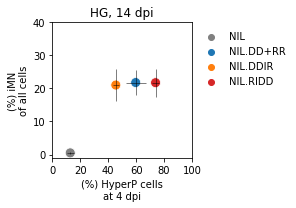

In [15]:
# Calc mean and SEM for each cond
grouping = ['cond']
data_both_mean = data_both.groupby(grouping).mean().reset_index()
data_both_SEM = data_both.groupby(grouping).sem().reset_index()

# Plotting params
x = '4dpi HyperP percent'
y = 'iMN percent'
hue = 'cond'
cond_list = ['NIL',
             'NIL.DD+RR', 'NIL.DDIR', 'NIL.RIDD']
palette = {
    'NIL': 'grey',
    'NIL.DD+RR': 'tab:blue',
    'NIL.DDIR': 'tab:orange',
    'NIL.RIDD': 'tab:red'}

# Plot
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5))

ax.errorbar(x=data_both_mean[x], y=data_both_mean[y],
            xerr=data_both_SEM[x], yerr=data_both_SEM[y],
            color='None', ecolor='black', elinewidth=0.5)
            
f = sns.scatterplot(ax=ax,
    data=data_both_mean,
    x=x, y=y, hue=hue,
    hue_order=cond_list,
    s=100, palette=palette)

sns.move_legend(ax, title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)
ax.xaxis.set_label_text('(%) HyperP cells\nat 4 dpi')
ax.yaxis.set_label_text('(%) iMN\nof all cells')
ax.set_xticks(np.arange(0, 110, 20))
ax.set_yticks(np.arange(0, 50, 10))
plt.title('HG, 14 dpi')

# plt.savefig(figpath + 'SI/14dpi_iMNpercent_v_hyperP.svg', bbox_inches='tight')

## Yield

Collapse it down

Text(0.5, 1.0, '14 dpi')

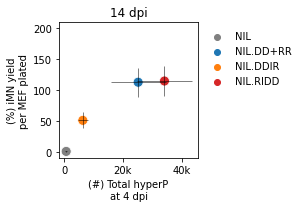

In [16]:
# Calc mean and SEM for each cond
grouping = ['cond']
data_both_mean = data_both.groupby(grouping).mean().reset_index()
data_both_SEM = data_both.groupby(grouping).sem().reset_index()

# Plotting params
x = '4dpi HyperP count'
y = 'iMN yield'
hue = 'cond'
cond_list = ['NIL',
             'NIL.DD+RR', 'NIL.DDIR', 'NIL.RIDD']
palette = {
    'NIL': 'grey',
    'NIL.DD+RR': 'tab:blue',
    'NIL.DDIR': 'tab:orange',
    'NIL.RIDD': 'tab:red'}

# Plot
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5))

ax.errorbar(x=data_both_mean[x], y=data_both_mean[y],
            xerr=data_both_SEM[x], yerr=data_both_SEM[y],
            color='None', ecolor='black', elinewidth=0.5)

f = sns.scatterplot(ax=ax,
    data=data_both_mean,
    x=x, y=y, hue=hue,
    hue_order=cond_list,
    s=100, palette=palette)

# Format
sns.move_legend(ax, title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)

ax.xaxis.set_label_text('(#) Total hyperP\nat 4 dpi')
ax.yaxis.set_label_text('(%) iMN yield\nper MEF plated')
# ax.set_xticks(np.arange(0, 110, 20))
k_formatter = FuncFormatter(lambda x, _: f'{x:.0f}' if abs(x) < 1000 else f'{x/1000:.0f}k')
ax.xaxis.set_major_formatter(k_formatter)
ax.set_yticks(np.arange(0, 201, 50))
ax.set_ylim(-10, 210)
plt.title('14 dpi')

# plt.savefig(figpath + 'SI/14dpi_iMNyield_v_hyperPcount.svg', bbox_inches='tight')